# Run FinalTestV2 and Visualise Results
This notebook:

1. Runs FinalTestV2.py as a script
2. Loads metrics.csv
3. Plots loss, training accuracy, and validation accuracy vs epoch
4. Loads dead-neuron CSVs and displays a heatmap

In [3]:
import os
import sys

PROJECT_ROOT = os.path.abspath(".") 
sys.path.insert(0, PROJECT_ROOT)


## RUN FINALTESTV2.PY

RUN: T1b_relu_sgd_bs256_epochs150


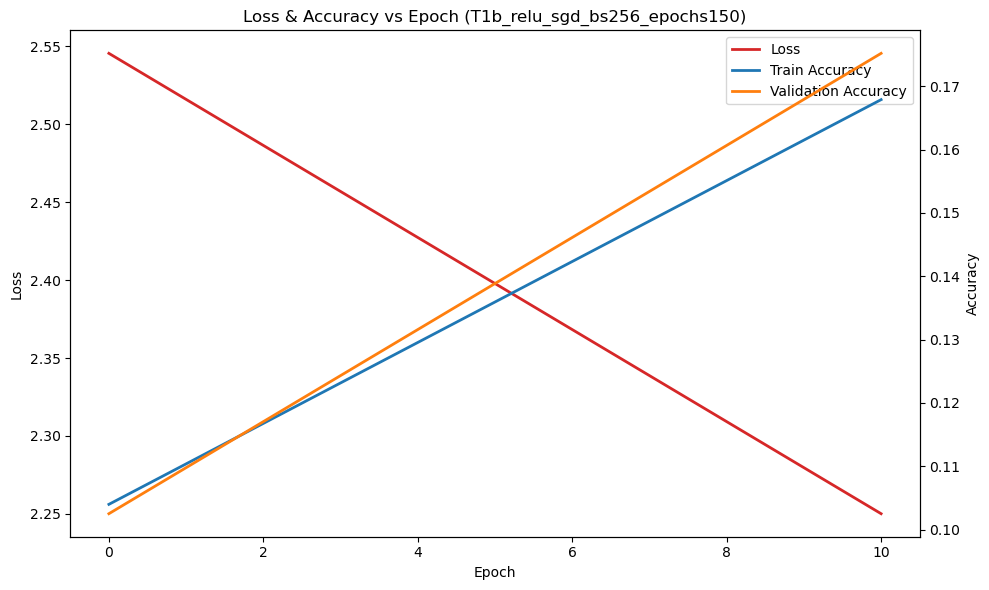

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

LOGS_DIR = "logs"

for run_name in sorted(os.listdir(LOGS_DIR)):
    run_path = os.path.join(LOGS_DIR, run_name)
    if not os.path.isdir(run_path):
        continue

    print("=" * 60)
    print(f"RUN: {run_name}")
    print("=" * 60)

    # ---- Metrics (combined plot with two Y axes) ----
    metrics_path = os.path.join(run_path, "metrics.csv")
    if os.path.exists(metrics_path):
        metrics = pd.read_csv(metrics_path)

        # 👇 High-resolution figure
        fig, ax1 = plt.subplots(figsize=(10, 6))

        # Loss on left Y-axis
        loss_line, = ax1.plot(
            metrics['epoch'],
            metrics['loss'],
            label='Loss',
            color='tab:red',
            linewidth=2
        )
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title(f"Loss & Accuracy vs Epoch ({run_name})")

        # Accuracy on right Y-axis
        ax2 = ax1.twinx()
        train_line, = ax2.plot(
            metrics['epoch'],
            metrics['train_accuracy'],
            label='Train Accuracy',
            linewidth=2
        )
        val_line, = ax2.plot(
            metrics['epoch'],
            metrics['validation_accuracy'],
            label='Validation Accuracy',
            linewidth=2
        )
        ax2.set_ylabel('Accuracy')

        # Combined legend
        lines = [loss_line, train_line, val_line]
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='best')

        plt.tight_layout()
        plt.show()
    else:
        print("No metrics.csv found")

    # ---- Dead neuron heatmaps ----
    for file in sorted(os.listdir(run_path)):
        if file.startswith("layer_") and file.endswith("_dead_neurons.csv"):
            layer_path = os.path.join(run_path, file)
            dead_df = pd.read_csv(layer_path)

            data = dead_df.drop(columns=['neuron']).values

            plt.figure(figsize=(10, 6), dpi=100)
            plt.imshow(data, aspect='auto')
            plt.colorbar(label='Dead (1) / Alive (0)')
            plt.xlabel('Epoch')
            plt.ylabel('Neuron index')
            plt.title(f"{file.replace('.csv','')} ({run_name})")
            plt.tight_layout()
            plt.show()


In [ ]:
import numpy as np
import time

from Cifar10Loader import Cifar10Loader
from neural_network import NeuralNetwork
from preprocessor import Preprocessor
from datacatcher import DataCatcher

from layers.activation_functions import ReLU, Sigmoid
from layers.optimisers import SGD, SGDWithMomentum, Adam
from layers.l2_regulariser import L2Regularizer
from layers.dropout import Dropout


CIFAR_DIR = "./dataset/cifar10"
BASE_DIR = "./task1-src/logs/"
EPOCHS = 101
BATCH_SIZE = 256

loader = Cifar10Loader(CIFAR_DIR)
X_train_raw, y_train_raw = loader.load_train_data()
X_test_raw, y_test_raw = loader.load_test_data()

preprocessor = Preprocessor()
X_train, y_train, X_val, y_val = preprocessor.preprocess_train_data(
    X_train_raw, y_train_raw, train_ratio=0.9
)
X_test, y_test = preprocessor.preprocess_test_data(
    X_test_raw, y_test_raw
)

print("Train:", X_train.shape)
print("Val  :", X_val.shape)
print("Test :", X_test.shape)

layer_config = [
    {
        "n_inputs": 3072,
        "n_neurons": 1024,
        "activation": ReLU(),
        "dropout": Dropout(keep_prob=0.8),
        "l2": L2Regularizer()
    },
    {
        "n_inputs": 1024,
        "n_neurons": 512,
        "activation": ReLU(),
        "dropout": Dropout(keep_prob=0.9),
        "l2": L2Regularizer()
    },
    {
        "n_inputs": 512,
        "n_neurons": 256,
        "activation": ReLU(),
        "dropout": None,
        "l2": L2Regularizer()
    },
    {
        "n_inputs": 256,
        "n_neurons": 10,
        "activation": None,
        "dropout": None,
        "l2": None
    }
]

data_catcher = DataCatcher(
    base_dir=BASE_DIR,
    config={
        "experiment_name": "cifar10_relu_1024_512_256_bs256",
        "metrics": True,
        "activation_logging": False,
        "activation_type": False,
        "layers": [0]
    }
)

network = NeuralNetwork(
    layer_config=layer_config,
    optimiser=SGDWithMomentum(
        learning_rate=0.05,
        decay=1e-3
    )
)

network.train(
    X=X_train,
    Y_true=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    data_catcher=data_catcher
)

data_catcher.save_activation_logs()